<a href="https://colab.research.google.com/github/yiit8/Wild-Cats-Classification/blob/main/Wild_Cats_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yigitgun","key":"7e7b8dbb28fdd39270fbf93220a6376f"}'}

In [2]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/


In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download "gpiosenka/cats-in-the-wild-image-classification"

 90% 111M/123M [00:01<00:00, 117MB/s]  
100% 123M/123M [00:01<00:00, 114MB/s]


In [ ]:
!unzip "/content/cats-in-the-wild-image-classification.zip" -d "/content/cats-in-the-wild-image-classification"

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

In [7]:
df = pd.read_csv("/content/cats-in-the-wild-image-classification/WILDCATS.CSV")

In [8]:
df.head()

,class id,filepaths,labels,data set,scientific name
0,0,train/AFRICAN LEOPARD/001.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
1,0,train/AFRICAN LEOPARD/002.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
2,0,train/AFRICAN LEOPARD/003.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
3,0,train/AFRICAN LEOPARD/004.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
4,0,train/AFRICAN LEOPARD/005.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus


JAGUAR             248
TIGER              247
AFRICAN LEOPARD    246
CARACAL            246
PUMA               246
CHEETAH            245
OCELOT             243
SNOW LEOPARD       241
CLOUDED LEOPARD    239
LIONS              238
Name: labels, dtype: int64
2439


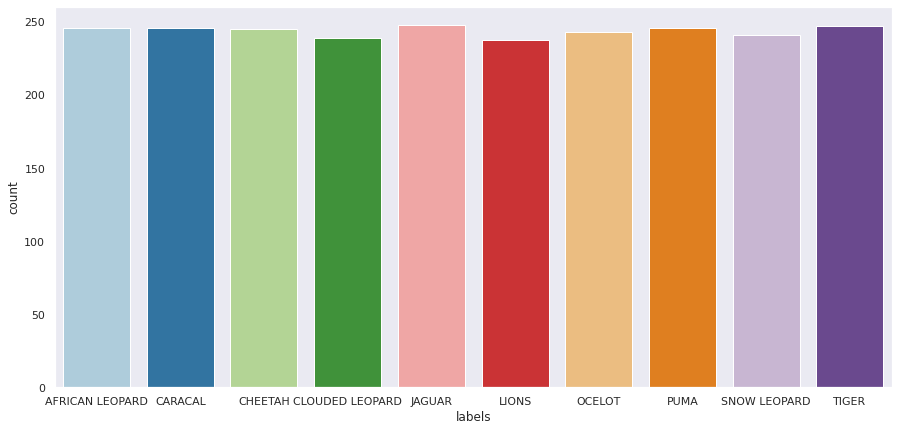

In [38]:
print(df['labels'].value_counts())
print(df['labels'].value_counts().sum())
plt.figure(figsize=(15,7))
sns.countplot(x='labels', data=df, palette='Paired')
plt.show()

In [55]:
# Data augmentation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(400),
        transforms.Resize(400),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(),
        transforms.GaussianBlur(kernel_size=(5,5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(400),
        transforms.CenterCrop(400),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/cats-in-the-wild-image-classification'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [45]:
print(class_names)


['AFRICAN LEOPARD', 'CARACAL', 'CHEETAH', 'CLOUDED LEOPARD', 'JAGUAR', 'LIONS', 'OCELOT', 'PUMA', 'SNOW LEOPARD', 'TIGER']


In [56]:
print(image_datasets['train'])
print('-' * 150)
print(image_datasets['valid'])

Dataset ImageFolder
    Number of datapoints: 2339
    Root location: /content/cats-in-the-wild-image-classification/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(400, 400), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               Resize(size=400, interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
               GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
------------------------------------------------------------------------------------------------------------------------------------------------------
Dataset ImageFolder
    Number of datapoints: 50
    Root location: /content/cats-in-the-wild-image-classifica

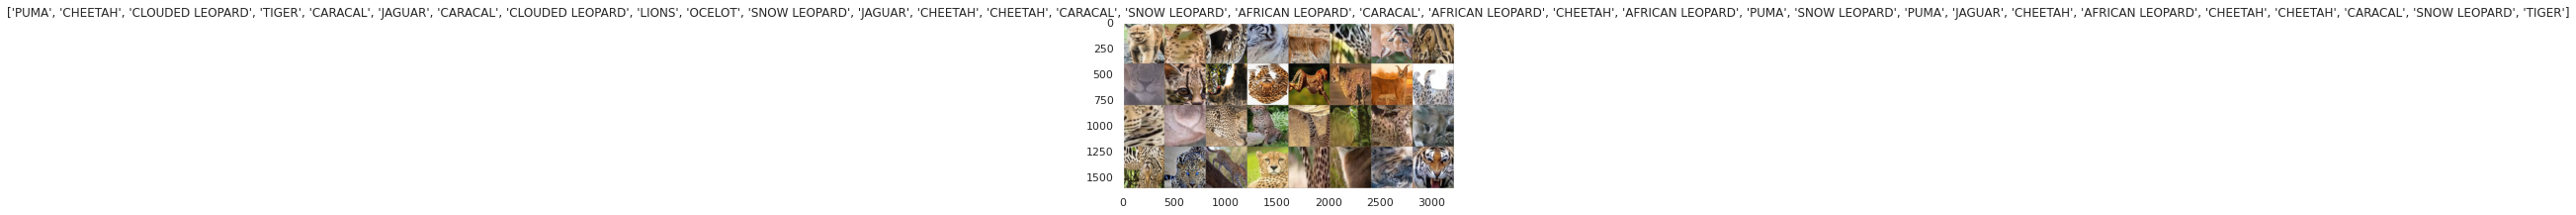

In [57]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])